# Read the Data

In [1]:
import pandas as pd
from tkinter import Tk
from tkinter.filedialog import askopenfilename
import csv
import chardet as ch

def browse_file():
    Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
    filename = askopenfilename() # show an "Open" dialog box and return the path to the selected file
    return filename

def load_data(fcsv,dlt, enc = 'ascii'):
    df = pd.read_csv(fcsv, delimiter = dlt, encoding = enc)
    pd.options.display.float_format = '{:.0f}'.format # Make pandas display in scientific format for all continuous computing
    return df

def csvcomma(fcsv) : # We want to find out the delimiter
    rawdata = open(fcsv).read()
    sniffer = csv.Sniffer()
    dialect = sniffer.sniff(rawdata)
    return dialect.delimiter

def csvencode(fcsv) : # csv encoding for good reading
    rawdata = open(fcsv,'rb').read()
    result = ch.detect(rawdata)
    charenc = result['encoding']
    return charenc

In [2]:
filecsv = browse_file()
delit = csvcomma(filecsv)
encd = csvencode(filecsv)
df = load_data(filecsv, delit, encd)
df.head()

,No,Period,AC,Zone,Monthly
0,1,2016 01,1011000000000,Zone 01,1284294
1,2,2016 02,1011000000000,Zone 01,1639863
2,3,2016 03,1011000000000,Zone 01,1
3,4,2016 04,1011000000000,Zone 01,1995432
4,5,2016 05,1011000000000,Zone 01,5365377


# Overview the Data

In [3]:
def overview(df) :
    print('This is the describe for data continuous :\n')
    print(df.describe())
    print('_'*80+'\n')
    print('This is the describe for data Object :\n')
    print(df.describe(include='O'))
    print('_'*80+'\n')
    print('This is head of data :\n')
    print(df.head(4))
    print('_'*80+'\n')
    print('This is type of data in each columns :\n')
    print(df.dtypes)
    print('_'*80+'\n')    
    print('This is number of NaN in data :\n')
    print(df.isna().sum())

overview(df)

This is the describe for data continuous :

          No            AC    Monthly
count 102239        102239     102239
mean   51120 1011326307378    5724675
std    29514     270408538   61125496
min        1 1011000000000          0
25%    25560 1011010000000          0
50%    51120 1011400000000          1
75%    76680 1011600000000     472468
max   102239 1012000000000 4695129768
________________________________________________________________________________

This is the describe for data Object :

         Period      Zone
count    102239    102239
unique       48        12
top     2019 12  National
freq       2444     15482
________________________________________________________________________________

This is head of data :

   No   Period            AC     Zone  Monthly
0   1  2016 01 1011000000000  Zone 01  1284294
1   2  2016 02 1011000000000  Zone 01  1639863
2   3  2016 03 1011000000000  Zone 01        1
3   4  2016 04 1011000000000  Zone 01  1995432
_____________________

In [4]:
##Customize the Date attribute
from datetime import datetime

def att_time(df, att, dlt) :
    new = df[att].str.split(dlt, n = 1, expand = True) #we split the period attribute into 2 columns by the space
    #display(new.head(3))
    df['Month'] = new[1]
    df['Year'] = new[0]
    #display(df.head(3)) # We got 2 columns with the month and year

    s1 = df['Month'].tolist()
    s2 = df['Year'].tolist()

    s3 = [] #make a container for date parsing
    for i in range(len(s1)) :
        s4 = '{}-{}-01'.format(s2[i], s1[i])
        s4 = datetime.strptime(s4,'%Y-%m-%d').date() #make it type date by parse the date format in string type
        s3.append(s4) #add the result into s3 list
    
    df['Date'] = s3 #make it part of Data attribute
    df.drop([att], axis = 1, inplace=True) #try to remove att attribute in data
    df.set_index('Date',inplace=True) #Set date attribute as the index
    #df.reset_index(inplace=True)
    display(df.head(3))
    
att_time(df, att='Period', dlt=' ')
df.rename(columns={'Monthly':'Num_Sales'}, inplace=True)
df.drop(['No'], axis=1, inplace=True)

,No,AC,Zone,Monthly,Month,Year
Date,,,,,,
2016-01-01,1,1011000000000,Zone 01,1284294,01,2016
2016-02-01,2,1011000000000,Zone 01,1639863,02,2016
2016-03-01,3,1011000000000,Zone 01,1,03,2016


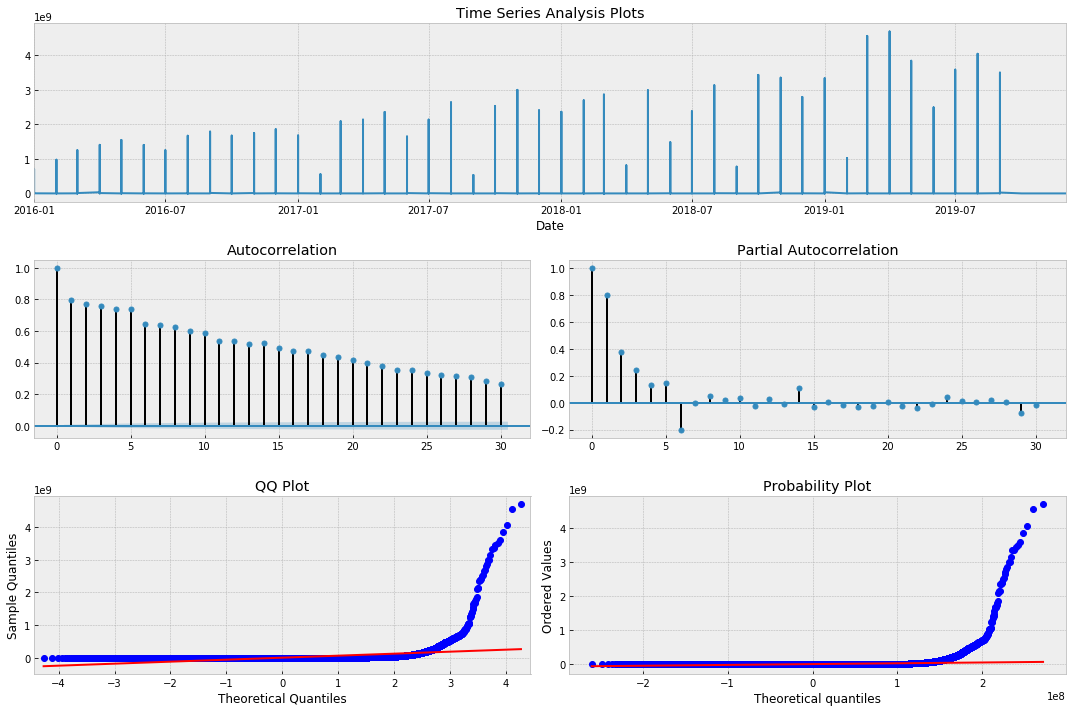

In [5]:
#import pandas as pd
#import numpy as np

#import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
        plt.show()
    return

randser = df['Num_Sales']
tsplot(randser, lags=30)

### Notes for plots here:

* The top plot is the values of time series itself (you can say it is scatter plot with the line)
* The second row has plots of autocorrelation (ACF) and partial autocorrelation (PACF). The PACF is partial correlation between residuals, controlling for shorter lags.
 * Still on second row, The x axis shows the values of the lag, $k$ and the blue shaded region show significance boundaries. Only values that lie outside the blue region are significant
* The third row has QQ plots and probability plots
 * **QQ plot** compares two probability distributions by plotting their quantiles against each other - If the two distributions are similar (orlinearly related), the points in the Q–Q plot will approximately lie on a line. For this discussion, we are comparing the distribution of our residuals with a normal distribution
 * Similarly, **normal probability** plot also asseses whether or not a data set is approximately normally distributed. The data are plotted against a theoretical normal distribution in such a way that the points should form an approximate straight line. Departures from this straight line indicate departures from normality.
 

### We note the following:

* The process appears to be random but it did not center about zero
* The autocorrelation (ACF) and partial autocorrelation (PACF) plots also indicate no significant serial correlation (Remember we should see approximately 5% significance in the autocorrelation plots due to pure chance as a result of sampling from the Normal distribution).
* Below that we can see the QQ and Probability Plots, which compares the distribution of our data with standard normal distribution are not straight lines. So this could not assume as normal distribution.

Serial correlation is the relationship between a variable and a lagged version of itself over various time intervals. Repeating patterns often show serial correlation when the level of a variable affects its future level.

Let's see for others criteria to make `TRAIN` and `TESTING` data.

In [6]:
def valcount(df, colnm) :
    print('Value count of ',colnm,' :\n')
    print(df[colnm].value_counts()) #for the value count about some criteria in attribute

valcount(df, 'AC')
print('_'*80+'\n')
valcount(df, 'Zone')

Value count of  AC  :

1011600000000    28596
1011000000000    23360
1011400000000    18294
1011100000000    13724
1011810000000     4815
1011200000000     4339
1011010000000     4119
1011700000000     2620
1011300000000     1935
1011500000000      270
1011900000000      119
1012000000000       48
Name: AC, dtype: int64
________________________________________________________________________________

Value count of  Zone  :

National       15482
Zone 05        10809
Zone 04         8810
Zone 02A        8580
Zone 01         8536
Zone 07         8479
Zone 08         8283
Zone 03         8200
Zone 06         7999
Zone 09         7827
Zone 02B        5383
Zone 02 AFH     3851
Name: Zone, dtype: int64


In [7]:
import datetime as dtm

def splitme(zone) :
    '''
    we try to filter the data, sort by the date index, and copy to other location in memory
    and we try to make test data and train data as 20 : 80
    The return file is dataframe in a list, so you need to make like this :
    Train data = Variable[0]
    Test data = Variable[1]
    '''
    #dftry = df[(df['AC']== ac) & (df['Zone']== zone) & (df.index < dtm.date(2019,10,1))].sort_index().copy()
    dftry = df[(df['Zone']== zone) & (df.index < dtm.date(2019,10,1))].sort_index().copy()
    size1 = int(round(dftry.shape[0] * .2)) #we make test data is 20% from real data
    size2 = int(dftry.shape[0] - size1) #this is 80% for train data
    train = dftry.iloc[ : size2,:]
    test = dftry.iloc[size2 : dftry.shape[0],:]
    return [train, test, size1]

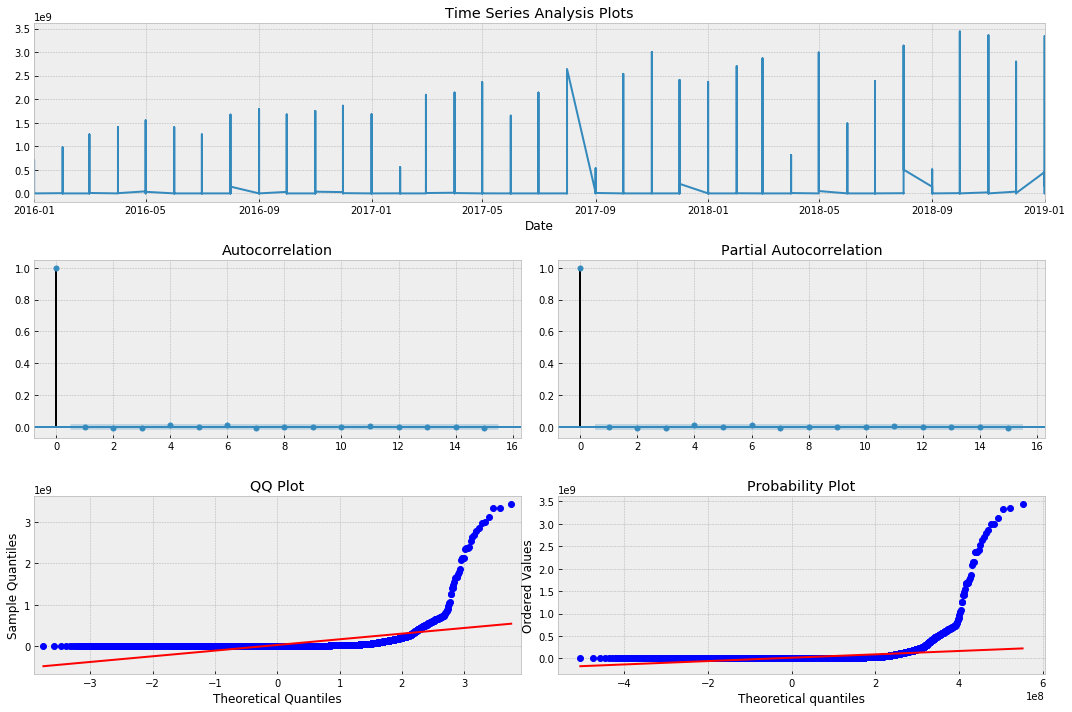

In [8]:
#Data01 = splitme(1011100000000, 'National')
Data01 = splitme('National')
tsplot(Data01[0].Num_Sales, lags=15)


Frequency 7


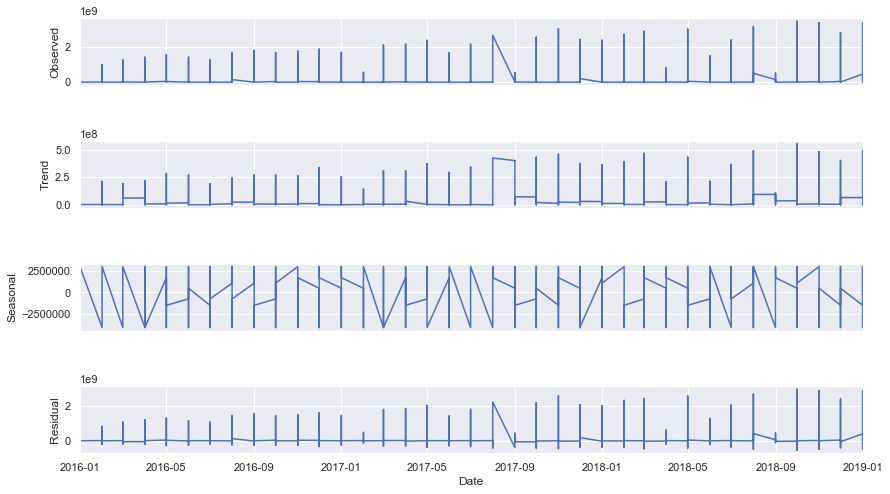

In [14]:
def Seasons(alp, df) :
    print('\nFrequency',alp)
    res = sm.tsa.seasonal_decompose(df.dropna(),freq=alp)
    fig = res.plot()
    fig.set_figheight(8)
    fig.set_figwidth(15)
    plt.show()

Seasons(7, Data01[0].Num_Sales)

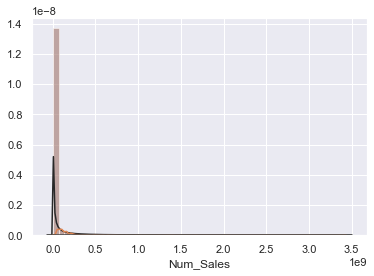

In [15]:
from scipy import stats
import seaborn as sns
sns.set(color_codes=True)
sns.distplot(Data01[0].Num_Sales, kde=False, fit=stats.lognorm)
sns.distplot(Data01[0].Num_Sales, kde=True, fit=stats.gamma)
plt.show()
#g = sns.FacetGrid(df, col='cols', hue="target", palette="Set1")
#g = (g.map(sns.distplot, "vals", hist=False, rug=True))

## Fitting Garch

In [16]:
'''
Fit a GARCH(1, 1) model to our simulated EPS series
We use the arch_model function from the ARCH package
This is GARCH (with a Constant Mean)
The default set of options produces a model with a constant mean, GARCH(1,1) conditional variance and normal errors.
'''
from arch import arch_model
import numpy as np

Train = Data01[0].Num_Sales
Test = Data01[1].Num_Sales

#am = arch_model(Train)
#res = am.fit(update_freq=100)
#print(res.summary())
def arcga(Train, means, vols) :
    '''
    1. mean (str, optional) – Name of the mean model. Currently supported options are:
    'Constant', 'Zero', 'ARX' and 'HARX'
    2. lags (int or list (int), optional) – Either a scalar integer value indicating lag 
    length or a list of integers specifying lag locations.
    3. vol (str, optional) – Name of the volatility model. Currently supported options are: 
    'GARCH' (default), 'ARCH', 'EGARCH', 'FIARCH' and 'HARCH'
    4. Please see the ACF and PCF plot, we know that for the first time, it was in outside box when it lays on 7th lag.
    
    Name of the error distribution. Currently supported options are:
    Normal: 'normal', 'gaussian' (default)
    Students's t: 't', 'studentst'
    Skewed Student's t: 'skewstudent', 'skewt'
    Generalized Error Distribution: 'ged', 'generalized error'
    '''
    modelga0 = arch_model(Train, mean=means, vol=vols, p=7, q=7, dist='Normal')
    FIT_GA0 = modelga0.fit(update_freq=100) # fit model
    print(FIT_GA0.summary())
    #split_date =  '2019-10-01'
    yhat = FIT_GA0.forecast(horizon=Data01[2], method='simulation', simulations=1000) # forecast the test set
    #yhat = FIT_GA0.forecast(horizon=Data01[2]) # forecast the test set
    #yhats = yhat.mean
    yhats = yhat.simulations
    # plot the actual variance
    #var = [i*0.01 for i in range(0,100)]
    #plt.plot(var[-Data01[2]:])
    # plot forecast variance
    #plt.plot(yhat.variance.values[-1, :])
    #plt.show()
    return [yhat, yhats]

In [17]:
test = arcga(Train, 'Zero', 'GARCH')
# https://arch.readthedocs.io/en/latest/univariate/forecasting.html
# https://stackoverflow.com/questions/50936449/forecast-with-garch-in-python
# http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016
# http://barnesanalytics.com/garch-models-in-python
# https://github.com/Rblivingstone/Book
# https://quant.stackexchange.com/questions/42240/predicting-stock-returns-with-garch-in-python
# https://quant.stackexchange.com/questions/16730/correctly-applying-garch-in-python
# https://machinelearningmastery.com/make-sample-forecasts-arima-python/

C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.886e+16. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1e-07 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 232495.8759160718
            Iterations: 7
            Function evaluations: 53
            Gradient evaluations: 3
                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Num_Sales   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -232496.
Distribution:                  Normal   AIC:                           465022.
Method:            Maximum Likelihood   BIC:                           465132.
                                        No. Observations:                11526
Date:                Fri, Dec 06 2019   Df Residuals:                    11511
Time:                        09:59:11   Df Model:                           15
                               Volatility Model                         

MemoryError: 

In [18]:
sims = test[1]
print(sims.values[-1,:,:].T)

lines = plt.plot(sims.values[-1,:,:].T, color='blue', alpha=0.01)
lines[0].set_label('Simulated paths')
plt.show()

print(np.percentile(sims.values[-1,:,-1].T,5))
plt.hist(sims.values[-1, :,-1],bins=50)
plt.title('Distribution of Returns')
plt.show()


#print(test[0].mean.tail())
#split_date =  np.datetime64('2019-10-01').value().astype('datetime64')
#type(split_date)

NameError: name 'test' is not defined

C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.886e+16. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1e-07 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)


Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 232326.90183502538
            Iterations: 15
            Function evaluations: 212
            Gradient evaluations: 11


C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Num_Sales   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -232327.
Distribution:                  Normal   AIC:                           464686.
Method:            Maximum Likelihood   BIC:                           464803.
                                        No. Observations:                11526
Date:                Fri, Dec 06 2019   Df Residuals:                    11510
Time:                        09:59:47   Df Model:                           16
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         2.3245e+07  1.282e+06     18.125  2.018e-73 [2.

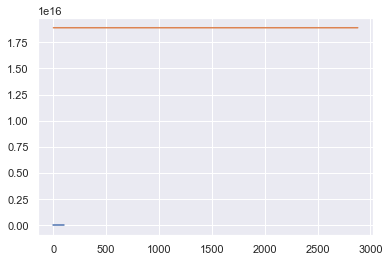

In [19]:
modelga0 = arch_model(Train, mean='Constant', vol='GARCH', p=7, q=7) #Please see the ACF and PCF plot, we know that for the first time, it was in outside box when it lays on 7th lag.
FIT_GA0 = modelga0.fit(update_freq=100) # fit model
yhat = FIT_GA0.forecast(horizon=Data01[2]) # forecast the test set
# plot the actual variance
print(FIT_GA0.summary())
var = [i*0.01 for i in range(0,100)]
plt.plot(var[-Data01[2]:])
# plot forecast variance
plt.plot(yhat.variance.values[-1, :])
plt.show()

### Fitting Arch

In [ ]:
# Now we can fit the arch model using the best fit arima model parameters

p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(model.resid, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

In [ ]:
order[0]

In [ ]:
Data01[2]